# Assignment #4 - Reinforcement Learning

<font color="blue"> Nishita Kalyanpur </font>

<font color="blue"> 801076677 </font>

# I. Overview

The objective of the assignment is to solve the blackjack problem using the Reinforcement Learning Agent. For this reason, the Temporal Difference(TD) Learning methods are learnt and one of them is implemented. In our case, SARSA (state-action-reward-state-action) is used. It is an off-policy algorithm for TD Learning.The assignment is accomplished by picking the bets and choosing an action from the Q table (where it learns the policies and updates the table till the iterations are complete); and from the rewards and the basic learning from the Q table, suitable actions are chosen to lead to the best possible outcome in the game.

# Methods

## Review of SARSA 
SARSA which stands for state-action-reward-state-action is an On-Policy algorithm for TD Learning. The maximum reward for the next state is not used for updating Q values. Q values are used in the control problems where it is used to evaluate the state and action altogether. Therefore, for the new action, a reward is selected using the same policy that determined the original action. A SARSA agent interacts with the environment and updates the policy based on the actions taken, hence this is known as an on-policy learning algorithm. The Q value for a state-action is updated by the rewards given, adjusted by the learning rate alpha. Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation.

## Review of Q-Learning
Q-Learning is an Off-Policy algorithm for Temporal Difference(TD) Learning. Without making any assumptions for the behavioural policy, other policies are explored and the Q values are updated. Hence it is termed as off policy algorithm. The learning rate or step size determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent consider only the most recent information (ignoring prior knowledge to explore possibilities).

## Choice of TD Learning
In the assignment, I've chosen SARSA as the choice for TD Learning as it is based on On-policy adaptation. It uses parameters such as t or t+1, for which, agent's action for the next state explicitly finds future reward values, next state observations rather than assuming that it is going to select the optimal parameter for the next state. Q values are used in the control problems where it is used to evaluate the state and action altogether. SARSA learns a near-optimal policy whilst exploring. SARSA will also approach convergence allowing for possible penalties from exploratory moves, whereas Q-learning will ignore them.

# Choice of Function Approximation and Reason
Reinforcement learning is understood by implementing TD Learning using tabular function approximation. Since the number of states and action aren't that large, it is easier to use tabular function approximation (Q table in this case). Not just the memory requirements, but also the time taken until it fills out the cells correctly can matter. This issue is refered as generalization. To produce a good estimation over unexperienced state space based on the experience from the limited set of the state space is known as function approximation. We've chosen around 50 dimensions as it takes 21 as a sum of cards to win the round. There are bets given in the range of 1 to 10. There is two possible actions which is either 0 or 1. And finally there is dealer's information based on the sum of his cards. Through these parameters, Q table is generated. And through learning and updating the table, the game is played.

# II. Problems 



## Blackjack

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />

Now, we play Blackjack! 
We have improved version of it from OpenAI Gym [Blackjack-V0](https://gym.openai.com/envs/Blackjack-v0/). Our blackjack has an additional betting option. Here follows the rule description. 


### <font color="red"> Game Introduction and Rules: </font>


Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).

The game starts with each player getting two face up cards and dealer
having one face up and face down card and the player needs to bet an 
amount of money within range of 1 to max bet (10). 
Note: Face up means that you will know what the card is.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
You won't see the dealer's facedown card, just you will know if you have or lost
and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
is drawn.
(It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)

If the player wins, the amount he has bet will be doubled and given back. 
If the player and dealer have the same sum, then its a draw and the player will get
back the money he has bet. 
If the player loses then, the money he bet will be lost. 
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. You are free to change the reward function to make it 
learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 

Regardless of the number of players on the table, each player will be just playing against the 
dealer independently of the other players.

## BlackJack Environment

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

### Player class definition

Player class defines an object for each BlackJack player with a given *unique* name. It has three attributes, the player's name, current cards in hand, and total balance left to play games.  <code>get_info()</code> is getter method that prints out all three attributes.

In [9]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

Following functions are utilities and definition of card deck to play games and to check the game status. 

In [11]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [2]:
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [8]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, evn):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def epsilon_greed(self, epsilon, s):
        if np.random.uniform() < epsilon:
            a = np.random.randint(self.n_a)
        else:
            i_max = np.where(self.Q[s[0], s[1], :] == np.max(self.Q[s[0], s[1], :]))[0]
            a = int(np.random.choice(i_max))
        return a
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
#         self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # update self.Q table (SARSA)
                self.Q[s[0], s[1], a] += alpha * (r + gamma * self.Q[s1[0], s1[1], a1] -\
                                             self.Q[s[0], s[1], a])

                if env.is_goal(): # reached the goal
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        epsilon = 0
        env.init(start)
        s = env.get_cur_state()
        # selection an action
        a = self.epsilon_greed(epsilon, s)

        trace = np.array(coord_convert(s, self.size))
        # run simulation for max number of steps 
        for step in range(maxstep):
            # move
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = self.epsilon_greed(epsilon, s1)

            trace = np.vstack((trace, coord_convert(s1, self.size)))

            if env.is_goal(): # reached the goal
                break

            s = s1
            a = a1 

        return trace 

# Implementation

# Explanation of the codes

As seen below, there's a game environment which performs fuction such as to bet money, add a player, reset etc. After defining the environment parameters, Blackjack Agent which is a reinforcement learning agent is implemented. It has following methods such as init, epsilon_greed, train and test. The init is used to initialize the parameters where the Q table is set to zero. 

In the train method, the game environment is set. The respective player(s) are added. In the number of games, the general observations are considered such as the player information which includes the the player's balance, sum card etc, and also the dealer's information. The information about the players and dealers is passed to the epsilon greed function where the actions are chosen. If the random parameter is less than epsilon, then the action and the betting amount is chosen randomely, else, the Q table which contains the action, players and dealers information, actions and the betting range is selected and its maximum reward is calculated. Which indicates the possible best action for the upcoming states. The action chosen in this method is then passed back, rewards are set based on the action chosen i.e. whether the player won or not. Based on it, the Q-table is updated using the SARSA learning method and its formula is implemented. This step continues until the game is over. 

In the test method, the similar steps are followed as the train, but it is carried for only one game with minimum number of rounds.


### Game Environment

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments. 

These are important member functions to be used by you:
1. add_player: You can add your player object with some initial amount of money

2. step: you need to send the action using this function, actions are hit(1) or stand(0)
        returns {'state': player info and dealer info (_get_obs), 
                 'reward': real-valued reward, 
                 'is_round_done': True/Fasle}
3. _get_obs: returns the state of the env or required information you can use to build your agent. 
             eg: {'player_info':{'player_sum_card': sum of cards, 
                                 'player_card': list of cards, 
                                 'player_total_balance': real-valued number, 
                                 'usable_ace' : True/False}, 
                 'dealer_info': dealer's first card}
4. init_round: will start a new round in the same game.
        returns {'state': player info and dealer info (_get_obs)}
          
5. reset: will reset the whole game and you will being again with the initial balance you had started the player object.
        returns nothing, will just reset the entire game.
          
6. bet_money: you can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10. 
        returns nothing.


In [326]:
class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        else:
            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}

In [439]:
class BlackjackAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, evn):
        self.env = BlackjackEnv()
#         self.size = env.get_size()
# #         self.n_a = len(env.get_actions())
#         # self.Q table including the surrounding border

        self.Q = np.zeros((50,50,10,2))
               

    def epsilon_greed(self, epsilon, s):
        
        if np.random.rand() < epsilon:
            a = np.random.randint(0,1)
            b = np.random.randint(1,10)
            
            return a,b
        else:
            u = s['player_info']['player_sum_card']
            
            v = s['dealer_info']
#           
            max_as = np.where(self.Q[u,v,:,:] == np.max(self.Q[[u],[v],:,:])) # index to action value            
            maxt = max(max_as[1])
            return max(max_as[1]), max(max_as[maxt])
                                                            
    
    def train(self, **params):
        
        env = BlackjackEnv()
        player1 = Player('player1')
        env.add_player(player1)
        #Number of games
        number_of_games = 100

        #Number of rounds
        number_of_rounds = 1000
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
              
        # init self.Q matrix
        self.Q[...] = 0
#         self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for _game in range(number_of_games):
            env.reset()
            print("-"* 50)
            print("Game Number: {}".format(_game + 1))
            print("-"* 50)
            for _round in range(number_of_rounds): 
                print("%"* 50)
                print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
                print("%"* 50)

                #Check if you have enough money left in the account to bet, if not break and start a new game
                valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
                if valid_bet_flag['is_round_done']:
                    print("You are out of money ! Will go to next game !!")
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']

                #Get the observations i.e state and use it to decide how much you want to bet
                round_obs = env.init_round(player1.player_name)
                print("Initial state: {}".format(round_obs)) 
                
                
                # If you have just $1 left in the bank, you have no choice but to bet that amount 
                # and hopefully leave it to the fate for your agent to win and continue playing or just
                # start a new game

                s = env._get_obs(player1.player_name)
                
                a = self.epsilon_greed(epsilon, s)
                
                bet = env.bet_money(player1.player_name, a[1])
                rewards = []
#                 if isinstance(a,tuple) == True:
#                     round_obs = env.step(player1.player_name, a[0])
#                 else:
                round_obs = env.step(player1.player_name, a[0])                
                r = round_obs['reward']
                print("State after 1st action: {}".format(round_obs))
                
                #Check if the game is not over, if your action is stand then the game is over, else
                #the game continues in this loop until your action is stand
                while not round_obs['is_round_done']:
                    s1 = env._get_obs(player1.player_name)
                    valid_bet_flag1 = env.get_valid_bet_amount(player1.player_name)
                    a1 = self.epsilon_greed(epsilon, s1)
                    print("Action taken: {}".format(a1))
                    u = s['player_info']['player_sum_card']
                    v = s['dealer_info']
                    round_obs = env.step(player1.player_name, a1[0])
                    r = round_obs['reward']
                    self.Q[u, v, a, bet] += alpha * (r + gamma * self.Q[u, v, a1, bet] -\
                                             self.Q[u, v, a, bet])
                    rewards.append(r)
                    print("State after nth action: {}".format(round_obs))
                
                
                print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
                print("Round over")
                print("-%-"*30)
                if (_round + 1) == (number_of_rounds):
                    print("Max number of rounds played. If you see this message, you are the winner.")
            
            rtrace.append(np.sum(rewards))
            steps.append(_round+1)
        return rtrace, steps

    

    def test(self, maxstep = 50):
        env = BlackjackEnv()
        epsilon = 0
        player1 = Player('player1')
        env.add_player(player1)
#         s = env._get_obs(player1.player_name)
#         # selection an action
#         a = self.epsilon_greed(epsilon, s)
        steps = []
        # run simulation for max number of steps 
        for step in range(maxstep):
            # move
            env.reset()
            valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
            if valid_bet_flag['is_round_done']:
                 print("You are out of money ! Will go to next game !!")
                 break
            bet_amount = valid_bet_flag['valid_bet_amount']

            #Get the observations i.e state and use it to decide how much you want to bet
            round_obs = env.init_round(player1.player_name)
            print("Initial state: {}".format(round_obs)) 


            # If you have just $1 left in the bank, you have no choice but to bet that amount 
            # and hopefully leave it to the fate for your agent to win and continue playing or just
            # start a new game

            s = env._get_obs(player1.player_name)

            a = self.epsilon_greed(epsilon, s)

            bet = env.bet_money(player1.player_name, a[1])
            rewards = []
#                 if isinstance(a,tuple) == True:
#                     round_obs = env.step(player1.player_name, a[0])
#                 else:
            round_obs = env.step(player1.player_name, a[0])                
            r = round_obs['reward']
            print("State after 1st action: {}".format(round_obs))

            #Check if the game is not over, if your action is stand then the game is over, else
            #the game continues in this loop until your action is stand
            while not round_obs['is_round_done']:
                s1 = env._get_obs(player1.player_name)
                valid_bet_flag1 = env.get_valid_bet_amount(player1.player_name)
                a1 = self.epsilon_greed(epsilon, s1)
                print("Action taken: {}".format(a1))
                u = s['player_info']['player_sum_card']
                v = s['dealer_info']
                round_obs = env.step(player1.player_name, a1[0])
                r = round_obs['reward']
                rewards.append(r)
                print("State after nth action: {}".format(round_obs))


            print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
            print("Round over")
            print("-%-"*30)
            if (_round + 1) == (number_of_rounds):
                print("Max number of rounds played. If you see this message, you are the winner.")
            
            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps

In [416]:
agent = BlackjackAgent(env)
rtrace, steps = agent.train( gamma=0.99, 
                      alpha=0.1, 
                      epsilon=0.1, 
                      maxiter=100, 
                      maxstep=1000)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 9, 'player_card': [5, 4], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 3}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [5, 4, 8], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 3}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 9
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [5, 4, 8, 10], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 3}, 'reward': -1, 'is_round_done': True}
Balance Left: 9
Round over
-%--%--

Initial state: {'state': {'player_info': {'player_sum_card': 8, 'player_card': [2, 6], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 7}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [2, 6, 1], 'player_total_balance': 7, 'usable_ace': True}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [2, 6, 1, 5], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 24, 'player_card': [2, 6, 1, 5, 10], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--

State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [5, 9, 3], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 6
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [5, 9, 3, 10], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 15 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Initial state: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [10, 10], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 5}}
player winner
State after 1st a

Game Number: 19 Round Number: 26
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 8
Initial state: {'state': {'player_info': {'player_sum_card': 8, 'player_card': [6, 2], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 4}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [6, 2, 9], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 4}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [6, 2, 9, 10], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 4}, 'reward': -1, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 19 Round Number: 27


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 27 Round Number: 7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Initial state: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [9, 10], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 1}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 26, 'player_card': [9, 10, 7], 'player_total_balance': 5, 'usable_ace': False}, 'dealer_info': 1}, 'reward': -1, 'is_round_done': True}
Balance Left: 5
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 27 Round Number: 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 5
Initial state: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [4, 1], 'player_total_balance': 5, 'usable_ace'

player name: player1 money left: 3
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [8, 4], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 7}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [8, 4, 1], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 2
Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [8, 4, 1, 6], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 2
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 22, 'player_card': [8, 4, 1, 6, 3], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 2
Rou

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 44 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 18
Initial state: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [4, 9], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 1}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [4, 9], 'player_total_balance': 12, 'usable_ace': False}, 'dealer_info': 1}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 12
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 44 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 12
Initial state: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [1, 10], 'player_total_balance': 12, 'usable_

Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [1, 9, 1, 10], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 9
Action taken: (0, 9)
player winner
State after nth action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [1, 9, 1, 10], 'player_total_balance': 11, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 11
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 49 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 11
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [2, 10], 'player_total_balance': 11, 'usable_ace': False}, 'dealer_info': 10}}
player loser, wont get back the money, 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 58 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 8
Initial state: {'state': {'player_info': {'player_sum_card': 18, 'player_card': [7, 1], 'player_total_balance': 8, 'usable_ace': True}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 18, 'player_card': [7, 1, 10], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [7, 1, 10, 3], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 31, 'player_card': [7,

player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 23, 'player_card': [10, 10, 3], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 4}, 'reward': -1, 'is_round_done': True}
Balance Left: 8
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 65 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 8
Initial state: {'state': {'player_info': {'player_sum_card': 9, 'player_card': [7, 2], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 9}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 9, 'player_card': [7, 2], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 9}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 2
Round over
-%--%--%--%--

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 72 Round Number: 12
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [2, 10], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 2}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 22, 'player_card': [2, 10, 10], 'player_total_balance': 0, 'usable_ace': False}, 'dealer_info': 2}, 'reward': -1, 'is_round_done': True}
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 72 Round Number: 13
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!
--------------------------------------------------
Game Number: 73
----------

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 8
Initial state: {'state': {'player_info': {'player_sum_card': 10, 'player_card': [8, 2], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 2}}
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 10, 'player_card': [8, 2], 'player_total_balance': 13, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 13
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 81 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 13
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [8, 4], 'player_total_balance': 13, 'usable_ace': False}, 'dealer_info': 3}}
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 12, 'playe

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 20
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [7, 5], 'player_total_balance': 20, 'usable_ace': False}, 'dealer_info': 8}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [7, 5, 9], 'player_total_balance': 19, 'usable_ace': False}, 'dealer_info': 8}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 19
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 31, 'player_card': [7, 5, 9, 10], 'player_total_balance': 19, 'usable_ace': False}, 'dealer_info': 8}, 'reward': -1, 'is_round_done': True}
Balance Left: 19
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 86 Round Number: 37
%%%%%%%%%%%%%%%%%%%%%%%%%%

Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [7, 3, 1, 6], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 3}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [7, 3, 1, 6, 10], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 3}, 'reward': -1, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 90 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Initial state: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [4, 9], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 3}}
State 

State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [6, 6, 5], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 10
Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 18, 'player_card': [6, 6, 5, 1], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 10
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 24, 'player_card': [6, 6, 5, 1, 6], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 10
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 95 Round Number: 10

In [417]:
def plot_train(rtrace, steps):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace, "b-")
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

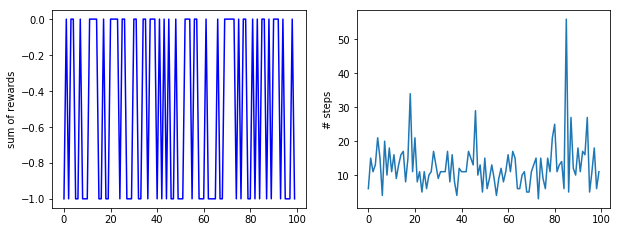

In [418]:
plot_train(rtrace, steps)

In [450]:
agent = BlackjackAgent(env)
rtrace, steps = agent.train( gamma=0.6, 
                      alpha=0.5, 
                      epsilon=0.9, 
                      maxiter=100, 
                      maxstep=1000)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 7, 'player_card': [5, 2], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 7, 'player_card': [5, 2], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
Initial state

player name: player1 money left: 21
Initial state: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [3, 10], 'player_total_balance': 21, 'usable_ace': False}, 'dealer_info': 1}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [3, 10], 'player_total_balance': 12, 'usable_ace': False}, 'dealer_info': 1}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 12
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 26 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 12
Initial state: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [10, 10], 'player_total_balance': 12, 'usable_ace': False}, 'dealer_info': 5}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_i

player name: player1 money left: 42
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [5, 7], 'player_total_balance': 42, 'usable_ace': False}, 'dealer_info': 5}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [5, 7], 'player_total_balance': 34, 'usable_ace': False}, 'dealer_info': 5}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 34
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 36 Round Number: 196
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 34
Initial state: {'state': {'player_info': {'player_sum_card': 8, 'player_card': [2, 6], 'player_total_balance': 34, 'usable_ace': False}, 'dealer_info': 5}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 50 Round Number: 144
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 121
Initial state: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [8, 9], 'player_total_balance': 121, 'usable_ace': False}, 'dealer_info': 7}}
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [8, 9], 'player_total_balance': 123, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 123
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 50 Round Number: 145
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 123
Initial state: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [9, 10], 'player_total_balance': 123, 'usable_ace': False}, 'dealer_info': 4}

player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 10, 'player_card': [7, 3], 'player_total_balance': 23, 'usable_ace': False}, 'dealer_info': 4}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 23
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 68 Round Number: 18
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 23
Initial state: {'state': {'player_info': {'player_sum_card': 9, 'player_card': [4, 5], 'player_total_balance': 23, 'usable_ace': False}, 'dealer_info': 8}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [4, 5, 10], 'player_total_balance': 22, 'usable_ace': False}, 'dealer_info': 8}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 22
Action taken: (0, 9)
player loser, wont get back the money, try next round
State after nth ac

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 18
Initial state: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [6, 8], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 1}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [6, 8], 'player_total_balance': 13, 'usable_ace': False}, 'dealer_info': 1}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 13
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 86 Round Number: 18
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 13
Initial state: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [6, 1], 'player_total_balance': 13, 'usable_ace': True}, 'dealer_info': 9}}
player winner
State after 1st action: {'state': {'p

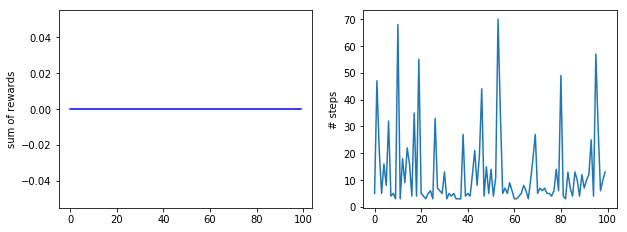

In [445]:
plot_train(rtrace, steps)

In [446]:
agent = BlackjackAgent(env)
rtrace, steps = agent.train( gamma=0.50, 
                      alpha=0.7, 
                      epsilon=0.5, 
                      maxiter=50, 
                      maxstep=100)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [9, 6], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 2}}
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [9, 6], 'player_total_balance': 12, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 12
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 12
Initial state: {'state': {'player_info': {'player_s

Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 18 Round Number: 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 19
Initial state: {'state': {'player_info': {'player_sum_card': 10, 'player_card': [6, 4], 'player_total_balance': 19, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [6, 4, 10], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 18
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 22, 'player_card': [6, 4, 10, 2], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 18
Round over
-%--%--%--%-

Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [2, 10], 'player_total_balance': 23, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [2, 10, 7], 'player_total_balance': 22, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 22
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 23, 'player_card': [2, 10, 7, 4], 'player_total_balance': 22, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 22
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 27 Round Number: 58
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 22
Initial state: {'stat

-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 45 Round Number: 54
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 8
Initial state: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [10, 10], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 7}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 28, 'player_card': [10, 10, 8], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 45 Round Number: 55
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Initial state: {'state': {'playe

Balance Left: 3
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 61 Round Number: 13
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Initial state: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [3, 10], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [3, 10, 7], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 2
Action taken: (0, 2)
Draw match
State after nth action: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [3, 10, 7], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0.0, 'is_round_done': True}
Balance Left: 3
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-

State after 1st action: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [7, 5, 3], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 3}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 7
Action taken: (0, 4)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [7, 5, 3], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 3}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 82 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Initial state: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [10, 4], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 1}}
State after 1st action: {'state': 

player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 23, 'player_card': [7, 10, 6], 'player_total_balance': 22, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 22
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 99 Round Number: 29
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 22
Initial state: {'state': {'player_info': {'player_sum_card': 13, 'player_card': [2, 1], 'player_total_balance': 22, 'usable_ace': True}, 'dealer_info': 2}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [2, 1, 4], 'player_total_balance': 21, 'usable_ace': True}, 'dealer_info': 2}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 21
Action taken: (0, 7)
player winner
State after nth 

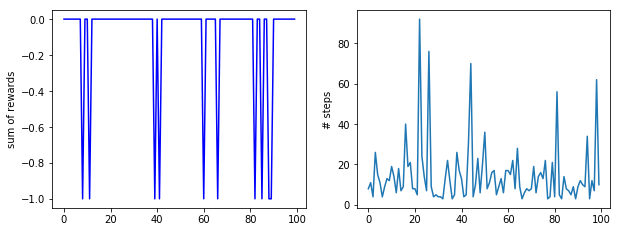

In [447]:
plot_train(rtrace, steps)

In [448]:
agent = BlackjackAgent(env)
rtrace, steps = agent.train( gamma=0.60, 
                      alpha=0.9, 
                      epsilon=0.1, 
                      maxiter=50, 
                      maxstep=100)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 11, 'player_card': [6, 5], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [6, 5, 4], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 9
Action taken: (1, 1)
State after nth action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [6, 5, 4, 4], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 9
Action taken: (1, 1)
player loser, wont get back t

-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 17 Round Number: 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 2
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [3, 9], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [3, 9, 7], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 1
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 29, 'player_card': [3, 9, 7, 10], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%

player name: player1 money left: 2
Initial state: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 1], 'player_total_balance': 2, 'usable_ace': True}, 'dealer_info': 8}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 1, 10], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 8}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 1
Action taken: (0, 5)
player winner
State after nth action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 1, 10], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 8}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 3
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 34 Round Number: 14
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Initial state: {'state': {'player_in

State after nth action: {'state': {'player_info': {'player_sum_card': 29, 'player_card': [10, 10, 1, 8], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 47 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Initial state: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [8, 6], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [8, 6, 5], 'player_total_balance': 5, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 5
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'stat

Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 29, 'player_card': [7, 7, 5, 10], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 64 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
Initial state: {'state': {'player_info': {'player_sum_card': 8, 'player_card': [4, 4], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 5}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [4, 4, 6], 'player_total_balance': 0, 'usable_ace': False}, 'dealer_info': 5}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 0
Action taken: (1, 1)
State after 

State after nth action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [7, 2, 3, 1, 6], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 2
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 29, 'player_card': [7, 2, 3, 1, 6, 10], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 2
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 77 Round Number: 18
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 2
Initial state: {'state': {'player_info': {'player_sum_card': 11, 'player_card': [8, 3], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 4}}
State after 1st acti

player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [6, 6], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 3}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [6, 6, 9], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 3}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 9
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 25, 'player_card': [6, 6, 9, 4], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 3}, 'reward': -1, 'is_round_done': True}
Balance Left: 9
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 93 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left:

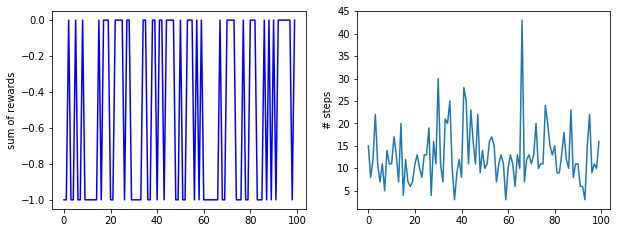

In [449]:
plot_train(rtrace, steps)

In [453]:
agent = BlackjackAgent(env)
rtrace, steps = agent.train( gamma=0.3, 
                      alpha=0.9, 
                      epsilon=0.1, 
                      maxiter=50, 
                      maxstep=100)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [6, 8], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 7}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 22, 'player_card': [6, 8, 8], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 9
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 9
Initial stat

State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [8, 3, 8], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 4}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 1
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 26, 'player_card': [8, 3, 8, 7], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 4}, 'reward': -1, 'is_round_done': True}
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 22 Round Number: 12
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
Initial state: {'state': {'player_info': {'player_sum_card': 10, 'player_card': [6, 4], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state'

player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 23, 'player_card': [4, 10, 9], 'player_total_balance': 4, 'usable_ace': False}, 'dealer_info': 2}, 'reward': -1, 'is_round_done': True}
Balance Left: 4
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 37 Round Number: 25
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 4
Initial state: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [5, 10], 'player_total_balance': 4, 'usable_ace': False}, 'dealer_info': 10}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [5, 10, 5], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 3
Action taken: (1, 1)
player loser, wont get back the

--------------------------------------------------
Game Number: 57
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 57 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 16, 'player_card': [8, 8], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 5}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 16, 'player_card': [8, 8], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 5}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 57 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Initial st

State after nth action: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [4, 1, 9], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 9}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 3
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 75 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Initial state: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [10, 10], 'player_total_balance': 3, 'usable_ace': False}, 'dealer_info': 10}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [10, 10, 7], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1, 'is_round_done': True}
Balance Left: 2
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--

Initial state: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [1, 10], 'player_total_balance': 7, 'usable_ace': True}, 'dealer_info': 2}}
State after 1st action: {'state': {'player_info': {'player_sum_card': 12, 'player_card': [1, 10, 1], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 0, 'is_round_done': False}
player name: player1 money left: 6
Action taken: (1, 1)
player loser, wont get back the money, try next round
State after nth action: {'state': {'player_info': {'player_sum_card': 22, 'player_card': [1, 10, 1, 10], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 2}, 'reward': -1, 'is_round_done': True}
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 93 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Initial state: {'state': {'play

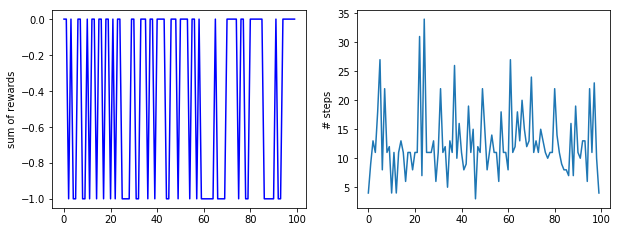

In [452]:
plot_train(rtrace, steps)

# Test Results

In [442]:
agent = BlackjackAgent(env)
rtracetest, stepstest = agent.test(maxstep=50)

player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 18, 'player_card': [8, 10], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 6}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 28, 'player_card': [8, 10, 10], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 6}, 'reward': -1, 'is_round_done': True}
Balance Left: 9
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 20, 'player_card': [10, 10], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 8}}
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 29, 'player_card': [10, 10, 9], 'player_total_balance': 9, 'usable_ace': False}, 'dealer_info': 8}, 'reward'

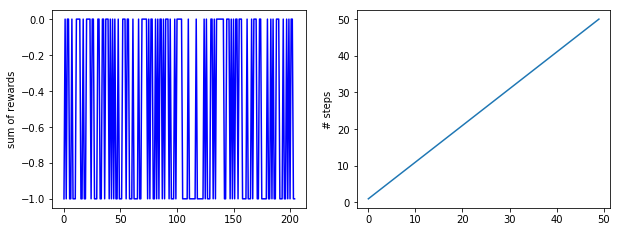

In [443]:
plot_train(rtracetest, stepstest)

# Reports the selected parameters

From the plots above, different parameters were given and as seen, different plots are generated.

In the first plot, the gamma is 0.99, alpha is 0.1 and epsilon 0.1 with maximum iteration as 100 and maximum step as 1000. As seen from the plots, the results aren't great. The reason could be that the apha which is the learning rate is considerably less.

In the second plot, the gamma is 0.6, aplha is 0.5 and epsilon is 0.9 with the maximum iteration as 100 and maximum step as 1000. The plot turned out to be the worst because there is no learning taking place as the epsilon is so high.

In the third plot, the gamma is 0.5, alpha is 0.7 and the epsilon is 0.5 with the maximum iteration as 50 and maximum step as 100. This plot gave better results as there aren't many negative rewards.

In the fourth plot, the gamma is 0.60, alpha is 0.9 and the epsilon is 0.1 with the maximum iteration as 50 and maximum step as 100. This plot is average too.

In the fifth plot, the gamma is 0.30, aplha is 0.9 and the epsilon is 0.1 with the maximum iteration as 50 and maximum step as 100. The plot gives better results than the previous one. 

# From the experimental outputs choice of the parameters.

As seen from the plots, many observations were made based on different parameters. From the plots, it can be seen which one turned out to be better than the rest. The deciding factors is the rewards and the number of steps taken to acheive it.

The Q value for a state-action is updated by an error, adjusted by the learning rate alpha. Hence, keeping alpha as 0.7 worked well in giving the results.

The discount factor(gamma) determines the importance of future rewards. A factor of 0 makes the agent "opportunistic" by only considering current rewards, while a factor approaching 1 will make it strive for a long-term high reward.By keeping gamma 0.5, it worked towards giving lesser negative rewards.

Also, lesser the epsilon, better the graph as there is more inclination towards exploitation of the possibilities. Here, the epsilon chosen is 0.5.

# Reading and analysis of learning results and plots

A SARSA agent interacts with the environment and updates the policy based on actions taken, hence this is known as an on-policy learning algorithm. The Q value for a state-action is updated by an error, adjusted by the learning rate alpha. Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation.

### Hyperparameters used...
 1. Learning Rate (alpha)
The learning rate determines to what extent newly acquired information overrides old information. A factor of 0 will make the agent not learn anything, while a factor of 1 would make the agent consider only the most recent information. In the plot, the learning rate is 0.7 and it helped in getting a better plot.

2. Discount Factor (gamma)
It determines the importance of future rewards. The gamma chosen here is 0.5 and the negative rewards were reduced considerably.


3. Epsilon
It gives the extent of which the exploitation of possiblities (be it action or the betting amount) that should be carried out. Lesser the epsilon, higher the exploitation and better the graphs.


# Maze problem

In [4]:
class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [5]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [6]:
def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace, "b-")
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

In [38]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

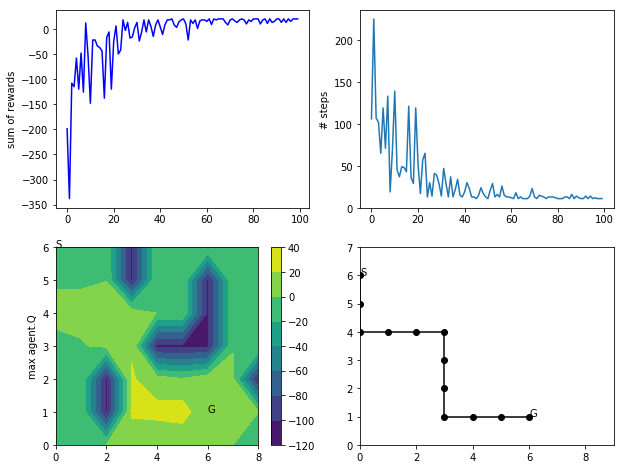

In [39]:
plot_train(agent, rtrace, steps, trace, start)

In [40]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.75, 
                                   alpha=0.01, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

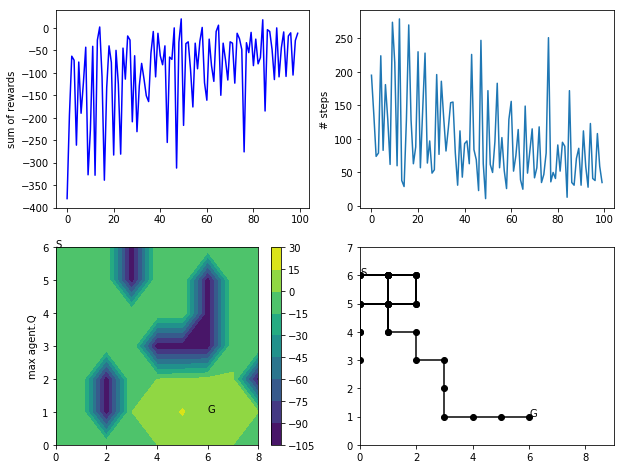

In [41]:
plot_train(agent, rtrace, steps, trace, start)

In [42]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.85, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

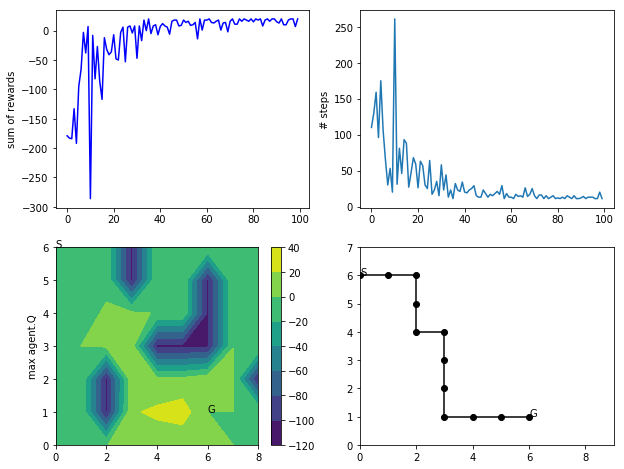

In [43]:
plot_train(agent, rtrace, steps, trace, start)

In [44]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.50, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

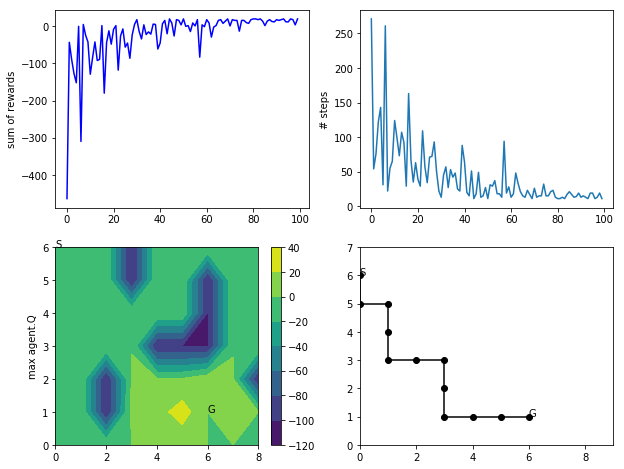

In [45]:
plot_train(agent, rtrace, steps, trace, start)

In [46]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.80,
                                   alpha=0.2, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

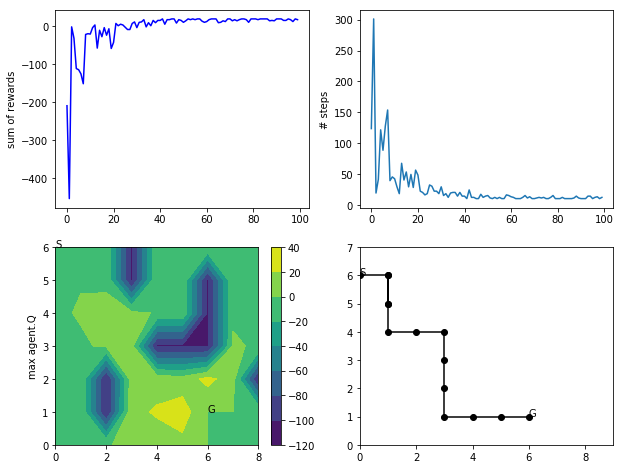

In [47]:
plot_train(agent, rtrace, steps, trace, start)

# V. Conclusions

In this assignment, the concepts of Reinforcement learning which includes the TD Learning methods such as SARSA and Q Learning were explored. Also, further understanding the hypermarameters used and its impact on the outcome.

#### Challenges faced
To understand how the game is played.

To understand how to implement epsilon greedy.

To determine which TD Learning method to use.

To determine which parameters will give the optimal results.
